In [ ]:
# Load in relevant libraries, and alias where appropriate
import torch
import torch.nn as nn
from torchvision import datasets
import torchvision
import torchvision.transforms as transforms
import numpy as np
    
# Hyperparameters
batch_size = 32
num_classes = 7
learning_rate = 0.01
num_epochs = 60
    
# Plotting parameters
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
#Loading the dataset and preprocessing
transform = transforms.Compose([
        transforms.Resize((32,32)),
        transforms.ToTensor(),
        transforms.Normalize(
                mean=[0.5551611804640287, 0.491291223366287, 0.44530976833072267],
            std=[0.2700789332643185, 0.254130887428006, 0.25608458818420854])])
   
# load the dataset
train_dataset = datasets.ImageFolder('dataset/train', transform=transform)
valid_dataset = datasets.ImageFolder('dataset/valid', transform=transform)   
test_dataset = datasets.ImageFolder('dataset/test', transform=transform)

    
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                               batch_size = batch_size,
                                               shuffle = True)

valid_loader = torch.utils.data.DataLoader(dataset = valid_dataset,
                                               batch_size = batch_size,
                                               shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                               batch_size = batch_size,
                                               shuffle = True)

In [ ]:
#Defining the convolutional neural network
class LeNet5(nn.Module):
    def __init__(self, num_classes):
        super(LeNet5, self).__init__()
        self.layer1 = nn.Sequential(
        nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),
        nn.BatchNorm2d(6),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer2 = nn.Sequential(
        nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Linear(400, 120)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(120, 84)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(84, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.relu(out)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

In [ ]:
model = LeNet5(num_classes).to(device)
    
#Setting the loss function
cost = nn.CrossEntropyLoss()
    
#Setting the optimizer with the model parameters and learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
#this is defined to print how many steps are remaining when training
total_step = len(train_loader)

In [ ]:
# Training the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    trn_corr = 0
    epoch_losses = 0
    for i, (images, labels) in enumerate(train_loader):  
        images = images.to(device)
        labels = labels.to(device)
            
        #Forward pass
        outputs = model(images)
        loss = cost(outputs, labels)
        #Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    # (NERI) TO TRACK THE LOSS AND CORRECT OF THE CNN
    epoch_losses.append(loss.item())  # Append every batch
    train_losses.append(sum(epoch_losses) / len(epoch_losses))  # Store epoch average
    train_correct.append(trn_corr)

# Validating the model
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs

    print('Accuracy of the network on the {} validation images: {} %'.format(3500, 100 * correct / total))

In [ ]:
# Test the model

model.eval()  # Set the model to evaluation mode

with torch.no_grad():
    correct = 0
    total = 0

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy of the network on the 10000 test images: {accuracy:.2f} %')

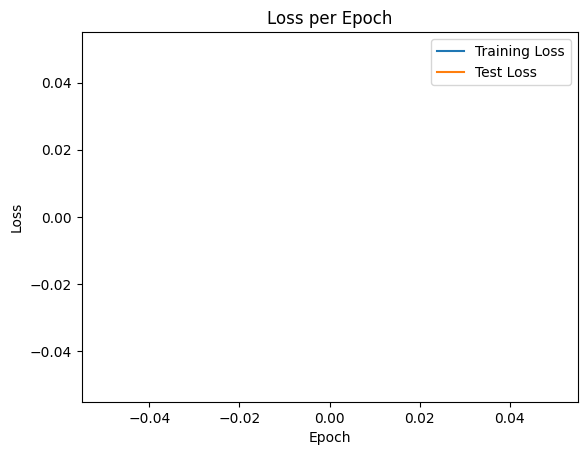

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
# GRAPH THE LOSS AT EPOCHS
# convert tensors to floats
train_loss_vals = [l.item() if isinstance(l, torch.Tensor) else float(l) for l in train_losses]
test_loss_vals  = [l.item() if isinstance(l, torch.Tensor) else float(l) for l in test_losses]

# Plot directly - already per-epoch
plt.plot(range(len(train_loss_vals)), train_loss_vals, label='Training Loss')
plt.plot(range(len(test_loss_vals)),  test_loss_vals,  label='Test Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# GRAPH ACCURACY PER EPOCH
# Convert tensors to CPU and then to a list of numbers for plotting
train_correct_cpu = [t.cpu().item() if isinstance(t, torch.Tensor) else t for t in train_correct]
test_correct_cpu = [t.cpu().item() if isinstance(t, torch.Tensor) else t for t in test_correct]

plt.plot([t/2450 for t in train_correct_cpu], label='Training Accuracy') # Use the CPU version for plotting
plt.plot([t/420 for t in test_correct_cpu], label = 'Validation Accuracy') # Use the CPU version for plotting
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show() 

In [ ]:
torch.save(model.state_dict(), 'Resnet_model(State_dict).pth')
torch.save(model, 'Resnet_model(Full model).pth')